<a href="https://colab.research.google.com/github/ludoveltz/test_github_fev25/blob/main/ADN_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q spacy==3.8.4
!python -m spacy download fr_core_news_md
!pip install -q transformers torch sentence-transformers seaborn networkx PyPDF2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 52.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import pandas as pd
import numpy as np
from transformers import pipeline
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from collections import Counter
import spacy
import re
from PyPDF2 import PdfReader
import io
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

In [3]:
try:
    nlp = spacy.load('fr_core_news_md')
    print("✅ SpaCy modèle français chargé avec succès")
except Exception as e:
    print(f"❌ Erreur lors du chargement du modèle SpaCy : {str(e)}")


✅ SpaCy modèle français chargé avec succès


🔄 Initialisation du système d'analyse...


Device set to use cuda:0


✅ Système initialisé

📁 CHARGEMENT DES DOCUMENTS
Veuillez sélectionner les fichiers PDF à analyser...


Saving Louis Vuitton x Takashi Murakami.pdf to Louis Vuitton x Takashi Murakami (6).pdf
Saving Sac Low Key Hobo MM.pdf to Sac Low Key Hobo MM.pdf
Saving Sac All In BB.pdf to Sac All In BB.pdf
Saving Sac … dos Montsouris PM.pdf to Sac … dos Montsouris PM.pdf
Saving Sac ceinture Low Key Bumbag.pdf to Sac ceinture Low Key Bumbag.pdf
Saving Mini Bumbag.pdf to Mini Bumbag.pdf
Saving Sac CarryAll MM.pdf to Sac CarryAll MM.pdf
Saving Pochette Accessoires LV x TM.pdf to Pochette Accessoires LV x TM.pdf
Saving Sac LV Biker MM.pdf to Sac LV Biker MM.pdf
Saving Sac Sunset Vibe.pdf to Sac Sunset Vibe.pdf
Saving Sac Atlantis GM.pdf to Sac Atlantis GM.pdf
Saving Sac Speedy BandouliŠre.pdf to Sac Speedy BandouliŠre (6).pdf
Saving Sac Camera Box.pdf to Sac Camera Box.pdf
Saving Sac Speedy Trunk 20.pdf to Sac Speedy Trunk 20.pdf
Saving Sac Nano Diane.pdf to Sac Nano Diane.pdf
Saving Sac Mini BoŒte Chapeau.pdf to Sac Mini BoŒte Chapeau.pdf
Saving Sac Rivage BB.pdf to Sac Rivage BB.pdf
Saving Pochette 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



🧬 RAPPORT D'ANALYSE

🎨 ANALYSE ADN DE MARQUE

📍 MARQUEURS DISTINCTIFS

• MATERIAUX_NOBLES:
  - textile
  - métal
  - canvas
  - toile
  - microfibre
  - veau
  - cuir

• SAVOIR_FAIRE:
  - confection
  - finition

• HERITAGE:
  - historique
  - maison
  - signature
  - héritage
  - tradition
  - emblématique

• INNOVATION:
  - moderne
  - innovant
  - contemporain
  - technique

• DESIGN:
  - motif
  - ligne
  - silhouette
  - graphique

👁️ CODES VISUELS

• PROPORTIONS:
  - rond

• MOTIFS:
  - monogram
  - signature
  - damier

• FINITIONS:
  - brillant
  - texturé
  - grainé
  - mat
  - lisse

• COULEURS:
  - blanc
  - argent
  - naturel
  - or
  - noir

🚀 INNOVATION
• Score d'innovation: 3.8%

• TECHNOLOGIE:
  - moderne
  - technique

• MATÉRIAUX:
  - innovant
  - technique

• PROCESSUS:
  - création

📜 HÉRITAGE
• Score d'héritage: 28.2%

• HISTOIRE:
  - tradition
  - maison
  - héritage

• RÉFÉRENCES:
  - signature
  - classique
  - emblématique

💰 POSITIONNEMENT PRIX
• Gamme: 1340.

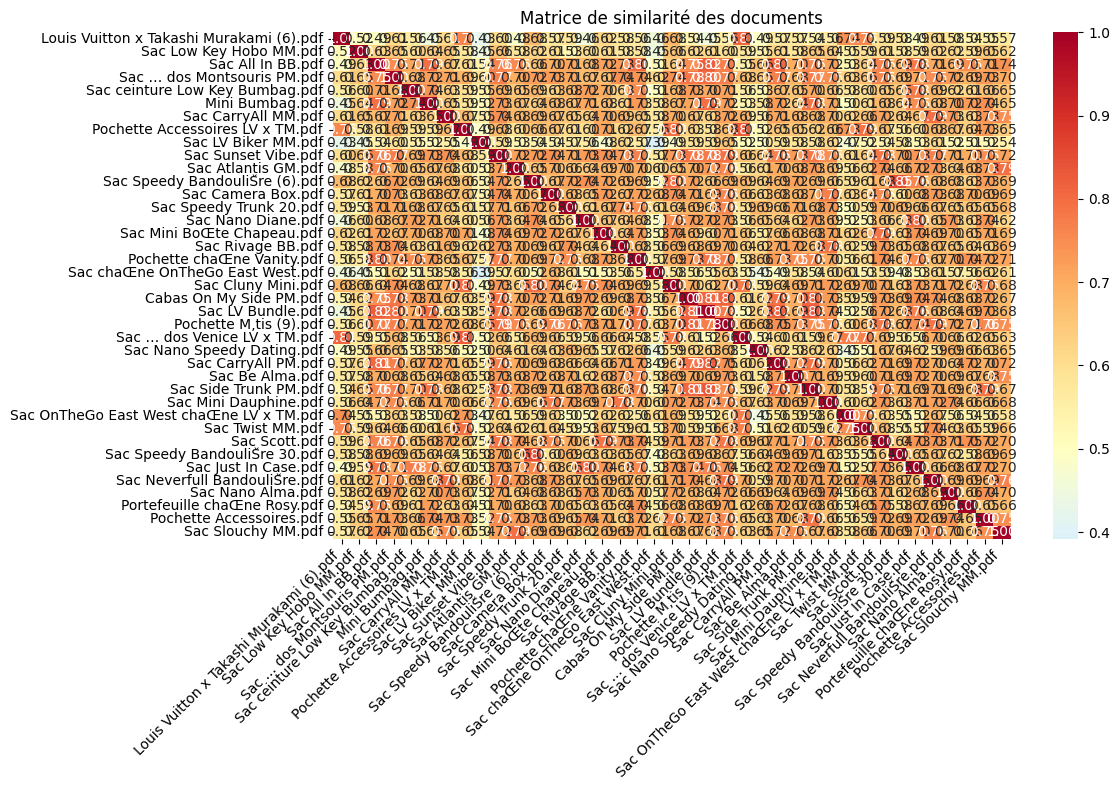

In [16]:
from datetime import datetime

class BrandDNAAnalyzer:
    def __init__(self):
        print("🔄 Initialisation du système d'analyse...")

        # Chargement du modèle SpaCy avec gestion d'erreurs
        try:
            self.nlp = spacy.load('fr_core_news_md')
        except OSError:
            print("⚠️ Installation du modèle français...")
            import subprocess
            subprocess.run(['python', '-m', 'spacy', 'download', 'fr_core_news_md'])
            self.nlp = spacy.load('fr_core_news_md')

        # Modèles d'analyse
        self.sentiment_analyzer = pipeline('sentiment-analysis',
                                        model='nlptown/bert-base-multilingual-uncased-sentiment',
                                        truncation=True)
        self.sentence_model = SentenceTransformer('distiluse-base-multilingual-cased')

        # Taxonomie luxe
        self.luxury_taxonomy = {
            'materiaux_nobles': [
                'cuir', 'veau', 'taurillon', 'toile', 'métal', 'laiton',
                'palladium', 'textile', 'soie', 'canvas', 'microfibre'
            ],
            'savoir_faire': [
                'couture', 'artisanal', 'fait main', 'sur mesure',
                'assemblage', 'finition', 'confection', 'façonné'
            ],
            'heritage': [
                'maison', 'tradition', 'archive', 'signature', 'emblématique',
                'iconique', 'patrimoine', 'héritage', 'historique'
            ],
            'innovation': [
                'contemporain', 'moderne', 'technique', 'technologique',
                'innovant', 'intelligent', 'modulable', 'nanotechnologie'
            ],
            'design': [
                'motif', 'structure', 'ligne', 'silhouette', 'proportion',
                'harmonie', 'pattern', 'graphique'
            ]
        }

        print("✅ Système initialisé")

    def extract_text_from_pdfs(self, pdf_files):
        """Extrait et prétraite le texte des PDFs"""
        texts = []
        for filename, content in pdf_files.items():
            try:
                reader = PdfReader(io.BytesIO(content))
                text = " ".join([page.extract_text() for page in reader.pages])
                text = re.sub(r'\s+', ' ', text)
                text = text.replace('\n', ' ').strip()
                texts.append(text)
            except Exception as e:
                print(f"⚠️ Erreur lors de la lecture de {filename}: {str(e)}")
        return texts

    def preprocess_text(self, text):
        """Prétraitement du texte"""
        doc = self.nlp(text.lower())
        tokens = [token.text for token in doc if not token.is_stop and not token.is_punct]
        return " ".join(tokens)

    def extract_price_range(self, texts):
        prices = []
        # Amélioration du pattern pour mieux détecter les prix
        pattern = r'(\d{1,4}(?:\s*\d{3})*)[,\s]*00?\s*€'

        for text in texts:
            if matches := re.findall(pattern, text):
                for match in matches:
                    try:
                        # Nettoyage et conversion plus robuste
                        price_str = match.replace(' ', '')
                        price = float(price_str)
                        if 100 <= price <= 10000:  # Filtre des prix réalistes
                            prices.append(price)
                    except ValueError:
                        continue

        if prices:
            return {
                'min': min(prices),
                'max': max(prices),
                'moyenne': np.mean(prices),
                'médiane': np.median(prices),
                'segments': {
                    'entrée de gamme': len([p for p in prices if p < 500]),
                    'milieu de gamme': len([p for p in prices if 500 <= p < 1500]),
                    'haut de gamme': len([p for p in prices if p >= 1500])
                }
            }
        return None

    def analyze_materials(self, texts):
        """Analyse des matériaux et finitions"""
        materials = []
        for text in texts:
            doc = self.nlp(text.lower())
            for token in doc:
                if any(mat in token.text for mat in self.luxury_taxonomy['materiaux_nobles']):
                    materials.append(token.text)
        return Counter(materials)

    def extract_key_features(self, texts):
        features = []
        key_patterns = [
            r"(?:^|[.!?]\s+)([^.!?]*(?:signature|emblématique|exclusif|unique)[^.!?]*[.!?])",
            r"(?:^|[.!?]\s+)([^.!?]*(?:collection|édition|série)[^.!?]*[.!?])",
            r"(?:^|[.!?]\s+)([^.!?]*(?:design|style|esthétique)[^.!?]*[.!?])"
        ]

        for text in texts:
            for pattern in key_patterns:
                matches = re.finditer(pattern, text, re.IGNORECASE)
                for match in matches:
                    feature = match.group(1).strip()
                    if 10 < len(feature) < 150:  # Filtrage par longueur
                        features.append(feature)

        # Dédoublonnage et tri par pertinence
        return list(set(features))

    def analyze_luxury_markers(self, text):
        """Analyse les marqueurs de luxe dans le texte"""
        markers = {category: [] for category in self.luxury_taxonomy.keys()}
        doc = self.nlp(text.lower())

        for category, terms in self.luxury_taxonomy.items():
            for term in terms:
                if term.lower() in text.lower():
                    context = self.get_context(text, term)
                    if context:
                        markers[category].append({
                            'term': term,
                            'context': context
                        })
        return markers

    def get_context(self, text, keyword, window=50):
        """Extrait le contexte autour d'un mot-clé"""
        index = text.lower().find(keyword.lower())
        if index != -1:
            start = max(0, index - window)
            end = min(len(text), index + len(keyword) + window)
            context = text[start:end].strip()
            context = re.sub(r'\s+', ' ', context)
            return context
        return None

    def analyze_visual_codes(self, texts):
        """Analyse des codes visuels distinctifs"""
        visual_codes = {
            'proportions': ['carré', 'rectangle', 'rond', 'ovale', 'géométrique'],
            'motifs': ['monogram', 'damier', 'rayures', 'logo', 'pattern', 'signature'],
            'finitions': ['mat', 'brillant', 'verni', 'grainé', 'lisse', 'texturé'],
            'couleurs': ['noir', 'blanc', 'or', 'argent', 'naturel', 'métallisé'],
            'techniques': ['surpiqûre', 'assemblage', 'couture', 'broderie', 'gravure']
        }

        codes_found = {category: [] for category in visual_codes}
        for text in texts:
            for category, elements in visual_codes.items():
                for element in elements:
                    if element in text.lower():
                        context = self.get_context(text, element)
                        if context:
                            codes_found[category].append({
                                'element': element,
                                'context': context
                            })
        return codes_found

    def analyze_innovation(self, texts):
        """Analyse des aspects innovants"""
        innovation_markers = {
            'technologie': ['technique', 'technologique', 'innovation', 'moderne', 'nouveau'],
            'matériaux': ['composite', 'technique', 'innovant', 'durable', 'recyclé'],
            'processus': ['développement', 'recherche', 'création', 'conception', 'élaboration'],
            'expérience': ['interactif', 'digital', 'connecté', 'intelligent', 'personnalisé']
        }

        innovation_score = 0
        innovation_details = {category: [] for category in innovation_markers}

        for text in texts:
            for category, markers in innovation_markers.items():
                for marker in markers:
                    if marker in text.lower():
                        context = self.get_context(text, marker)
                        if context:
                            innovation_score += 1
                            innovation_details[category].append({
                                'marker': marker,
                                'context': context
                            })

        return {
            'score': innovation_score / (len(texts) * len(innovation_markers)),
            'details': innovation_details
        }

    def analyze_heritage(self, texts):
        """Analyse de l'héritage et de la tradition"""
        heritage_markers = {
            'histoire': ['maison', 'tradition', 'héritage'],
            'savoir_faire': ['artisanat', 'expertise', 'métier', 'excellence'],
            'références': ['signature', 'emblématique', 'iconique', 'classique'],
            'valeurs': ['authenticité', 'qualité', 'excellence', 'prestige']
        }

        heritage_score = 0
        heritage_details = {category: [] for category in heritage_markers}

        for text in texts:
            for category, markers in heritage_markers.items():
                for marker in markers:
                    if marker in text.lower():
                        context = self.get_context(text, marker)
                        if context:
                            heritage_score += 1
                            heritage_details[category].append({
                                'marker': marker,
                                'context': context
                            })

        return {
            'score': heritage_score / (len(texts) * len(heritage_markers)),
            'details': heritage_details
        }

    def analyze_brand_dna(self, texts, filenames):
        """Analyse complète de l'ADN de la marque selon la méthodologie Solweig & Izar"""
        analysis = {
            'marqueurs_luxe': {},
            'signatures_visuelles': [],
            'elements_techniques': [],
            'positionnement_prix': self.extract_price_range(texts),
            'heritage_maison': [],
            'expertise_ai': {
                'workflows': [],
                'technologies': [],
                'innovations': []
            },
            'identite_creative': {
                'codes_visuels': [],
                'signatures': [],
                'storytelling': []
            }
        }

        # Analyse des marqueurs par catégorie
        for text in texts:
            markers = self.analyze_luxury_markers(text)
            for category, items in markers.items():
                if category not in analysis['marqueurs_luxe']:
                    analysis['marqueurs_luxe'][category] = []
                analysis['marqueurs_luxe'][category].extend(items)

        # Analyse approfondie
        analysis['codes_visuels'] = self.analyze_visual_codes(texts)
        analysis['innovation'] = self.analyze_innovation(texts)
        analysis['heritage'] = self.analyze_heritage(texts)

        # Analyse des aspects techniques et créatifs
        materials = self.analyze_materials(texts)
        key_features = self.extract_key_features(texts)

        # Analyse de l'expertise AI
        ai_expertise = {
            'workflows': ['dataset', 'normalisation', 'training', 'génératif'],
            'technologies': ['machine learning', 'vision par ordinateur', 'deep learning'],
            'innovations': ['hyperréalisme', 'fusion art-tech', 'préservation identité']
        }

        for text in texts:
            for category, terms in ai_expertise.items():
                found_terms = []
                for term in terms:
                    if term.lower() in text.lower():
                        found_terms.append(term)
                analysis['expertise_ai'][category].extend(found_terms)

        # Analyse identité créative
        creative_markers = {
            'codes_visuels': ['proportion', 'harmonie', 'technique', 'signature'],
            'signatures': ['timeless', 'impactful', 'luxe', 'innovation'],
            'storytelling': ['heritage', 'futur', 'artisanat', 'technologie']
        }

        for text in texts:
            for category, terms in creative_markers.items():
                found_terms = []
                for term in terms:
                    if term.lower() in text.lower():
                        found_terms.append(term)
                analysis['identite_creative'][category].extend(found_terms)

        # Analyse de similarité enrichie
        similarity_analysis = self.analyze_similarity_matrix(texts, filenames)

        # Embeddings et analyse sémantique
        processed_texts = [self.preprocess_text(text) for text in texts]
        embeddings = self.sentence_model.encode(processed_texts)
        similarity_matrix = cosine_similarity(embeddings)

        # Analyse des sentiments et perception
        sentiments = [self.sentiment_analyzer(text[:512])[0] for text in texts]

        # Mise à jour finale de l'analyse
        analysis.update({
            'materials': dict(materials),
            'key_features': key_features,
            'similarity_analysis': similarity_analysis,
            'similarity_matrix': similarity_matrix,
            'sentiments': sentiments,
            'metadata': {
                'nombre_documents': len(texts),
                'date_analyse': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'version_modele': '2.0'
            }
        })

        # Génération du rapport de similarité
        similarity_report = self.generate_similarity_report(similarity_analysis)
        analysis['similarity_report'] = similarity_report

        return analysis


    def analyze_similarity_matrix(self, texts, filenames):
        """Analyse détaillée de la similarité entre documents"""
        # Préparation des textes
        processed_texts = [self.preprocess_text(text) for text in texts]
        embeddings = self.sentence_model.encode(processed_texts)
        similarity_matrix = cosine_similarity(embeddings)

        # Création d'une analyse interprétable
        similarity_analysis = {
            'matrix': similarity_matrix,
            'document_pairs': [],
            'interpretation': {
                'très_forte': [],  # >0.8
                'forte': [],       # 0.6-0.8
                'moyenne': [],     # 0.4-0.6
                'faible': []       # <0.4
            }
        }

        # Analyse des paires de documents
        for i in range(len(texts)):
            for j in range(i+1, len(texts)):
                score = similarity_matrix[i][j]
                pair = {
                    'doc1': filenames[i],
                    'doc2': filenames[j],
                    'score': score,
                    'thèmes_communs': self.find_common_themes(texts[i], texts[j])
                }
                similarity_analysis['document_pairs'].append(pair)

                # Classification par niveau de similarité
                if score > 0.8:
                    similarity_analysis['interpretation']['très_forte'].append(pair)
                elif score > 0.6:
                    similarity_analysis['interpretation']['forte'].append(pair)
                elif score > 0.4:
                    similarity_analysis['interpretation']['moyenne'].append(pair)
                else:
                    similarity_analysis['interpretation']['faible'].append(pair)

        return similarity_analysis

    def find_common_themes(self, text1, text2):
        """Identifie les thèmes communs entre deux textes"""
        themes = []

        # Analyse des catégories de la taxonomie
        for category, terms in self.luxury_taxonomy.items():
            common_terms = []
            for term in terms:
                if term in text1.lower() and term in text2.lower():
                    common_terms.append(term)
            if common_terms:
                themes.append({
                    'catégorie': category,
                    'termes': common_terms
                })

        return themes

    def generate_similarity_report(self, similarity_analysis):
        """Génère un rapport détaillé de la similarité"""
        report = []
        report.append("\n📊 ANALYSE DE SIMILARITÉ")
        report.append("=====================")

        # Synthèse globale
        report.append("\n🔍 SYNTHÈSE DES SIMILARITÉS:")

        # Vérification si nous avons des paires de documents
        if len(similarity_analysis['document_pairs']) > 0:
            for niveau, pairs in similarity_analysis['interpretation'].items():
                if pairs:
                    report.append(f"\n• Similarité {niveau.replace('_', ' ')} ({len(pairs)} paires):")
                    for pair in pairs:
                        report.append(f"  - {pair['doc1']} × {pair['doc2']}: {pair['score']:.2%}")
                        if pair['thèmes_communs']:
                            report.append("    Thèmes partagés:")
                            for theme in pair['thèmes_communs']:
                                report.append(f"    · {theme['catégorie']}: {', '.join(theme['termes'])}")
        else:
            report.append("\n• Analyse impossible : document unique")

        return "\n".join(report)

    def generate_dna_report(self, analysis):
        """Génération du rapport d'analyse"""
        report = []
        report.append("\n🎨 ANALYSE ADN DE MARQUE")
        report.append("=====================")

        # Marqueurs distinctifs
        if analysis['marqueurs_luxe']:
            report.append("\n📍 MARQUEURS DISTINCTIFS")
            for category, markers in analysis['marqueurs_luxe'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_terms = set(m['term'] for m in markers)
                    for term in unique_terms:
                        report.append(f"  - {term}")

        # Section Codes Visuels
        if analysis.get('codes_visuels'):
            report.append("\n👁️ CODES VISUELS")
            for category, elements in analysis['codes_visuels'].items():
                if elements:
                    report.append(f"\n• {category.upper()}:")
                    unique_elements = set(e['element'] for e in elements)
                    for element in unique_elements:
                        report.append(f"  - {element}")

        # Section Innovation
        if analysis.get('innovation'):
            report.append("\n🚀 INNOVATION")
            report.append(f"• Score d'innovation: {analysis['innovation']['score']:.1%}")
            for category, markers in analysis['innovation']['details'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_markers = set(m['marker'] for m in markers)
                    for marker in unique_markers:
                        report.append(f"  - {marker}")

        # Nouvelle section Héritage
        if analysis.get('heritage'):
            report.append("\n📜 HÉRITAGE")
            report.append(f"• Score d'héritage: {analysis['heritage']['score']:.1%}")
            for category, markers in analysis['heritage']['details'].items():
                if markers:
                    report.append(f"\n• {category.upper()}:")
                    unique_markers = set(m['marker'] for m in markers)
                    for marker in unique_markers:
                        report.append(f"  - {marker}")

        # Analyse prix
        if analysis['positionnement_prix']:
            report.append("\n💰 POSITIONNEMENT PRIX")
            report.append(f"• Gamme: {analysis['positionnement_prix']['min']}€ - {analysis['positionnement_prix']['max']}€")
            report.append(f"• Moyenne: {analysis['positionnement_prix']['moyenne']:.2f}€")
            report.append("• Segmentation:")
            for segment, count in analysis['positionnement_prix']['segments'].items():
                report.append(f"  - {segment}: {count} produits")

        # Matériaux signatures
        if analysis['materials']:
            report.append("\n🎨 MATÉRIAUX SIGNATURES")
            for material, count in sorted(analysis['materials'].items(), key=lambda x: x[1], reverse=True)[:5]:
                report.append(f"• {material}: {count} mentions")

        # Caractéristiques distinctives
        if analysis['key_features']:
            report.append("\n✨ CARACTÉRISTIQUES DISTINCTIVES")
            key_features_sample = list(set(analysis['key_features']))[:5]
            for feature in key_features_sample:
                report.append(f"• {feature}")

        # Analyse des sentiments
        if analysis['sentiments']:
            positive_sentiments = len([s for s in analysis['sentiments'] if int(s['label'][0]) > 3])
            sentiment_ratio = positive_sentiments / len(analysis['sentiments'])
            report.append(f"\n🎯 PERCEPTION GÉNÉRALE")
            report.append(f"• Indice de prestige: {sentiment_ratio:.2%}")

        return "\n".join(report)

def analyze_brand_dna():
    """Fonction principale d'analyse selon la méthodologie Solweig & Izar"""
    # Imports nécessaires
    from google.colab import files
    import matplotlib.pyplot as plt
    import seaborn as sns
    import os

    analyzer = BrandDNAAnalyzer()

    print("\n📁 CHARGEMENT DES DOCUMENTS")
    print("========================")
    print("Veuillez sélectionner les fichiers PDF à analyser...")

    try:
        uploaded = files.upload()

        if not uploaded:
            print("❌ Aucun document uploadé")
            return

        filenames = list(uploaded.keys())
        print(f"\n✅ {len(uploaded)} document(s) chargé(s) avec succès:")
        for filename in filenames:
            print(f"  • {filename}")

        print(f"\n📊 ANALYSE EN COURS")
        print("=================")

        # Extraction du texte
        texts = analyzer.extract_text_from_pdfs(uploaded)

        if not texts:
            print("❌ Erreur: Impossible d'extraire le texte des documents")
            return

        # Analyse complète
        analysis = analyzer.analyze_brand_dna(texts, filenames)
        report = analyzer.generate_dna_report(analysis)

        # Affichage des rapports
        print("\n🧬 RAPPORT D'ANALYSE")
        print("==================")
        print(report)

        print("\n📊 ANALYSE DE SIMILARITÉ")
        print("==================")
        print(analysis['similarity_report'])

        # Visualisation améliorée
        if len(filenames) > 1:  # Seulement si nous avons plus d'un document
            plt.figure(figsize=(12, 8))

            # Création de la heatmap
            sns.heatmap(analysis['similarity_matrix'],
                        cmap='RdYlBu_r',
                        xticklabels=[os.path.basename(f) for f in filenames],
                        yticklabels=[os.path.basename(f) for f in filenames],
                        annot=True,
                        fmt='.2f',
                        center=0.5)

            plt.title("Matrice de similarité des documents")
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        else:
            print("\n📌 Note: La visualisation de similarité nécessite au moins deux documents.")

    except Exception as e:
        print(f"\n❌ Une erreur est survenue: {str(e)}")
        raise e

if __name__ == "__main__":
    analyze_brand_dna()


